# Decomposing the Gender Wage Gap

In this notebook, we investigate how much of the gender wage gap in real census data can be attributed to differences in education or occupation between women and men. We use the multiply-robust causal change attribution method from the following paper:
>Quintas-Martínez, V., Bahadori, M. T., Santiago, E., Mu, J. and Heckerman, D. "Multiply-Robust Causal Change Attribution," *Proceedings of the 41 st International Conference on Machine Learning*, Vienna, Austria. PMLR 235, 2024.

### Read and prepare data

We will be working with data from the Current Population Survey (CPS) 2015. After applying the same sample restrictions as [Chernozhukov et al. (2018)](https://arxiv.org/abs/1512.05635), the resulting sample contains 18,137 male and 14,382 female employed individuals.

In [1]:
import pandas as pd

# Read and prepare data:
df = pd.read_csv('./cps2015.csv')

# LightGBM works best with integer encoding for categorical variables:
educ_int = {'lhs' : 0, 'hsg' : 1, 'sc' : 2, 'cg' : 3, 'ad' : 4}
df['education'] = pd.from_dummies(df[['lhs', 'hsg', 'sc', 'cg', 'ad']])
df['education'] = df['education'].replace(educ_int)

df = df[['female', 'education', 'occ2', 'wage', 'weight']]
df.columns = ['female', 'education', 'occupation', 'wage', 'weight']
df[['education', 'occupation']] = df[['education', 'occupation']].astype('category')

# We want to explain the change Male -> Female:
data_old, data_new = df.loc[df.female == 0], df.loc[df.female == 1]

/tmp/ipykernel_12719/2548711999.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['education'] = df['education'].replace(educ_int)


### Causal Model

To use our causal change attribution method, we need a causal model linking the outcome (wage) and explanatory variables. (In practice, the method only requires knowing a *causal ordering*.) We will work with the following DAG:

<img src="./images/gender_gap_DAG.png" width="250" style="margin:auto"/>

The DAG above implies the following causal Markov factorization of the distribution of the data:
$$P(\mathtt{wage} \mid \mathtt{occup}, \mathtt{educ}) \times P(\mathtt{occup} \mid \mathtt{educ}) \times P(\mathtt{educ})$$
Each of the components of this factorization (the distribution of each node in the DAG given its direct causes) is called a *causal mechanism*. Differences in the marginal distribution of the wage between men and women could be due to differences in each causal mechanism. Our goal is going to be to disentangle the contribution of each one to the total change.

In the code below, we define a ```dowhy.gcm``` causal model:

In [2]:
import networkx as nx
import dowhy.gcm as gcm

dag = nx.DiGraph([('education', 'occupation'), ('occupation', 'wage'), ('education', 'wage')])
causal_model = gcm.ProbabilisticCausalModel(dag)

### Implementation with ```dowhy.gcm.distribution_change_robust```

First, we show how to compute a causal change attribution measure (Shapley values) using the ```dowhy.gcm.distribution_change_robust``` function.

The multiply-robust causal change attribution method is based on a combination of *regression* and *re-weighting* approaches. In the regression approach, we learn the dependence between a node and its parents in one sample, and then use the data from the other sample to shift the distribution of that node. In the re-weighting approach, we average the data giving more weight to those observations that closely resemble the target distribution. 

By default, ```dowhy.gcm.distribution_change_robust``` uses linear and logistic regression to learn the regression function and the weights. Here, since our dataset is quite large, we will use the more flexible algorithms ```HistGradientBoostingRegressor``` and ```HistGradientBoostingClassifier``` instead.

We also use ```IsotonicRegression``` to calibrate the probabilities that make up the weights for the re-weighting approach on a leave-out calibration sample. This is optional, but it has been shown to improve the performance of the method in simulations.

Finally, since our dataset is large, we will use sample splitting (rather than cross-fitting). That is, we will randomly split our data in a training set, where we learn the regression and weights, and an evaluation set, where we use the regression and weights to compute the final attribution measures.

In [3]:
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from dowhy.gcm.ml.classification import SklearnClassificationModelWeighted
from dowhy.gcm.ml.regression import SklearnRegressionModelWeighted
from dowhy.gcm.util.general import auto_apply_encoders, auto_fit_encoders, shape_into_2d

def make_custom_regressor():
    return SklearnRegressionModelWeighted(HistGradientBoostingRegressor(random_state = 0))

def make_custom_classifier():
    return SklearnClassificationModelWeighted(HistGradientBoostingClassifier(random_state = 0))

def make_custom_calibrator():
    return SklearnRegressionModelWeighted(IsotonicRegression(out_of_bounds = 'clip'))

gcm.distribution_change_robust(causal_model, data_old, data_new, 'wage', sample_weight = 'weight',
                               xfit = False, calib_size = 0.2,
                               regressor = make_custom_regressor,
                               classifier = make_custom_classifier,
                               calibrator = make_custom_calibrator)

Evaluating set functions...:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating set functions...: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

Evaluating set functions...: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

{'education': np.float64(1.1321504485335492),
 'occupation': np.float64(-2.0786979433836734),
 'wage': np.float64(-6.809529336261436)}

The function returns a dictionary, where each value is the Shapley Value causal attribution measure for the causal mechanism corresponding to the key. (See the research paper for a formal definition of Shapley Values.) We give a more in depth interpretation of the results in the final section of this notebook.

### Manual Implementation (Advanced)

Second, we show how to implement the method more directly with the class ```dowhy.gcm.distribution_change_robust.ThetaC```, which allows for more advanced capabilities, including computing standard errors via the Gaussian multiplier bootstrap (see below).

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Split data into train and test set:
X = df[['education', 'occupation']].values
y = df['wage'].values
T = df['female'].values
w = df['weight'].values

# To get the same train-test split:
kf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 0)
train_index, test_index = next(kf.split(X, T))

X_train, X_eval, y_train, y_eval, T_train, T_eval = X[train_index], X[test_index], y[train_index], y[test_index], T[train_index], T[test_index]
w_train, w_eval = w[train_index], w[test_index]

X_calib, X_train, _, y_train, T_calib, T_train, w_calib, w_train = train_test_split(X_train, y_train, T_train, w_train, 
                                                                                    train_size = 0.2, stratify = T_train, random_state = 0)

In [5]:
import itertools
from dowhy.gcm.distribution_change_robust import ThetaC
import numpy as np
from math import comb

# All combinations of 0s and 1s, needed for Shapley Values:
all_combos = [list(i) for i in itertools.product([0, 1], repeat=3)]
all_combos_minus1 = [list(i) for i in itertools.product([0, 1], repeat=2)]

# Dictionary to store the multiply-robust scores, will be used later for bootstrap:
scores = {}

# Here we compute the theta^c parameters that make up the Shapley Values (see paper):
for C in all_combos:
    scores[''.join(str(x) for x in C)] = ThetaC(C).est_scores(
        X_eval,
        y_eval,
        T_eval,
        X_train,
        y_train,
        T_train,
        w_eval=w_eval,
        w_train=w_train,
        X_calib=X_calib,
        T_calib=T_calib,
        w_calib=w_calib,
        regressor = make_custom_regressor,
        classifier = make_custom_classifier,
        calibrator = make_custom_calibrator)

# This function combines the theta^c parameters to obtain Shapley values:
w_sort = np.concatenate((w_eval[T_eval==0], w_eval[T_eval==1])) # Order weights in same way as scores

def compute_attr_measure(res_dict, path=False):
    # Alternative to Shapley Value: along-a-causal-path (see paper)
    if path: 
        path = np.zeros(3)
        path[0] = np.average(res_dict['100'], weights=w_sort) - np.average(res_dict['000'], weights=w_sort)
        path[1] = np.average(res_dict['110'], weights=w_sort) - np.average(res_dict['100'], weights=w_sort)
        path[2] = np.average(res_dict['111'], weights=w_sort) - np.average(res_dict['110'], weights=w_sort)
        return path
    
    # Shapley values:
    else: 
        shap = np.zeros(3)
        for k in range(3):
            sv = 0.0
            for C in all_combos_minus1:
                C1 = np.insert(C, k, True)
                C0 = np.insert(C, k, False)
                chg = (np.average(res_dict[''.join(map(lambda x : str(int(x)), C1))], weights=w_sort) - 
                       np.average(res_dict[''.join(map(lambda x : str(int(x)), C0))], weights=w_sort))
                sv += chg/(3*comb(2, np.sum(C)))
            shap[k] = sv
        return shap

shap = compute_attr_measure(scores, path=False)
shap # Should coincide with the above

array([ 1.13215045, -2.07869794, -6.80952934])

Thanks to the multiple robustness property, we can compute standard errors using a quick form of the bootstrap, which does not require re-estimating the regression and weights at each bootstrap iteration. Instead, we just re-weight the data using i.i.d. Normal(0, 1) draws.

In [6]:
w_sort = np.concatenate((w_eval[T_eval==0], w_eval[T_eval==1])) # Order weights in same way as scores

def mult_boot(res_dict, Nsim=1000, path=False):
    thetas = np.zeros((8, Nsim))
    attr = np.zeros((3, Nsim))
    for s in range(Nsim):
        np.random.seed(s)
        new_scores = {}
        for k, x in res_dict.items():
            new_scores[k] = x + np.random.normal(0,1, X_eval.shape[0])*(x - np.average(x, weights=w_sort))
        thetas[:, s] = np.average(np.array([x for k, x in new_scores.items()]), axis=1, weights=w_sort)
        attr[:, s] = compute_attr_measure(new_scores, path)
    return np.std(attr, axis=1)
    
shap_se = mult_boot(scores, path=False)
shap_se

array([0.34144275, 0.35141792, 0.35805933])

We can present the results visually in a graph, as in the paper:

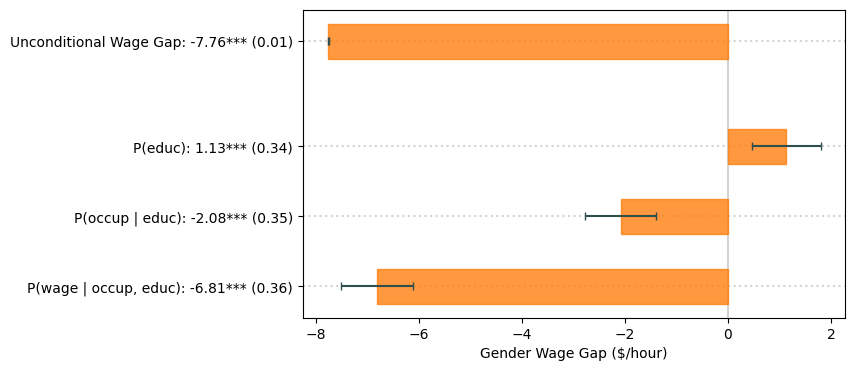

In [7]:
from scipy.stats import norm
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# Significance stars:
def star(est, se):
    if np.abs(est/se)<norm.ppf(.95): # 10%
        return ''
    elif np.abs(est/se)<norm.ppf(.975): # 5%
        return '*'
    elif np.abs(est/se)<norm.ppf(.995): # 1%
        return '**'
    else:
        return '***'

# Unconditional wage gap:
stats0 = DescrStatsW(y_eval[T_eval==0], weights=w_eval[T_eval==0], ddof=0)
stats1 = DescrStatsW(y_eval[T_eval==1], weights=w_eval[T_eval==1], ddof=0)

wagegap = (stats1.mean - stats0.mean)
wagegap_se = np.sqrt(stats1.std_mean**2 + stats0.std_mean**2)

# Plot
nam = ["P(educ)", "P(occup | educ)", "P(wage | occup, educ)"]

crit = norm.ppf(.975) # 5% critical value (for error bars)
stars = [star(est, se) for est, se in zip(shap, shap_se)]
fig, ax = plt.subplots()
ax.axvline(x = 0, color='lightgray', zorder=0)
fig.set_size_inches(7, 4)

color = 'C1' 
ax.add_patch(Rectangle((0, 4.75), width = wagegap, height = 0.5, color=color, alpha=0.8))
ax.plot((wagegap-crit*wagegap_se, wagegap+crit*wagegap_se,), (5.0, 5.0), color='darkslategray', marker='|', solid_capstyle='butt')
ax.axhline(y = 5.0, color='lightgray', linestyle='dotted', zorder=0)

for i in range(len(shap)):
    pos = (shap[i], 3-i+0.25) if shap[i] < 0 else (0, 3-i+0.25)
    width = np.abs(shap[i])
    ax.add_patch(Rectangle(pos, width = width, height = 0.5, color=color, alpha=0.8))
    ax.axhline(y = 3+0.5-i, color='lightgray', linestyle='dotted', zorder=0)
    ax.plot((shap[i]-crit*shap_se[i], shap[i]+crit*shap_se[i]), (3-i+0.5, 3-i+0.5), color='darkslategray', marker='|', solid_capstyle='butt')
plt.yticks([5.0] + [3+0.5-i for i in range(3)], [f'Unconditional Wage Gap: {wagegap:.2f}*** ({wagegap_se:.2f})'] + 
           ["{}: {:.2f}{} ({:.2f})".format(nam[i], shap[i], stars[i], shap_se[i]) for i in range(3)])
plt.xlabel('Gender Wage Gap ($/hour)')
plt.show()

### Interpretation

First, notice that the Shapley values for $P(\mathtt{educ})$, $P(\mathtt{occup} \mid \mathtt{educ})$ and $P(\mathtt{wage} \mid \mathtt{occup}, \mathtt{educ})$ add up to the total effect.

Second, the Shapley value for $P(\mathtt{educ})$ is positive and statistically significant. One way to interpret this measure is that, if men and women differed only in their $P(\mathtt{educ})$ (but their other causal mechanisms were the same), women would earn \\$1.13/hour more than men on average. Conversely, the Shapley value for $P(\mathtt{educ} \mid \mathtt{educ})$ is negative, statistically significant and of larger magnitude as the first Shapley value, hence cancelling out with the effect of differences in education. These effects measure two things:
1. How different is a causal mechanism between males and females?
2. How important is a causal mechanism for the outcome?

Third, most of the unconditional wage gap is attributed to the causal mechanism $P(\mathtt{wage} \mid \mathtt{occup}, \mathtt{educ})$. This can be interpreted in various ways:
1. *Unexplained variation*: There could be other relevant variables that we are not measuring, which are subsumed into $P(\mathtt{wage} \mid \mathtt{occup}, \mathtt{educ})$. For example, there could be differences in experience between men and women which are not measured in the CPS data. Notice that this does not bias our results for the other Shapley values, because experience is not a direct cause of education or occupation.
2. *Structural differences*: A different interpretation is that, for some reason (which may or may not be discrimination), women and men with the same observable characteristics are paid differently.

Below we try to make sense of this with some plots. First, notice how women tend to have higher education levels than men. For comparison, a college graduate earns \\$12.60/hour more on average than a high-school graduate.

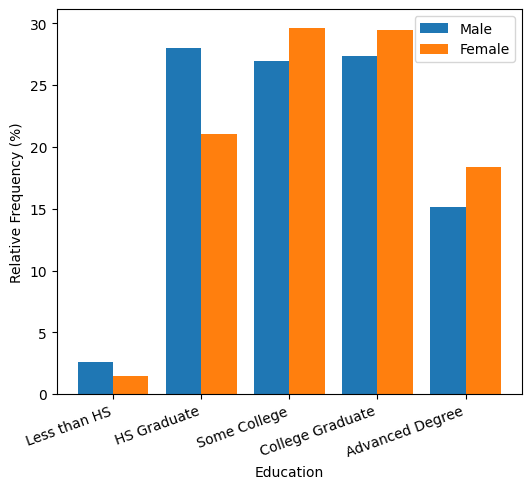

College vs. HS: 12.60


In [8]:
w0, w1 = w_eval[T_eval==0], w_eval[T_eval==1]

data_male_eval = pd.DataFrame({'education' : X_eval[:,0][T_eval==0], 
                              'occupation' : X_eval[:,1][T_eval==0],
                              'wage' : y_eval[T_eval==0]})
data_female_eval = pd.DataFrame({'education' : X_eval[:,0][T_eval==1], 
                              'occupation' : X_eval[:,1][T_eval==1],
                              'wage' : y_eval[T_eval==1]})

educ_names = {0 : 'Less than HS', 1 : 'HS Graduate', 2 : 'Some College', 3 : 'College Graduate', 4 : 'Advanced Degree'}
data_male_eval['education'] = data_male_eval['education'].replace(educ_names)
data_female_eval['education'] = data_female_eval['education'].replace(educ_names)

cats_educ = [educ_names[i] for i in range(5)]

ind = np.arange(len(cats_educ))
share0, share1 = np.zeros(len(cats_educ)), np.zeros(len(cats_educ))
for i, c in enumerate(cats_educ):
    share0[i] = np.sum(w0*(data_male_eval['education'] == c))/np.sum(w0)*100
    share1[i] = np.sum(w1*(data_female_eval['education'] == c))/np.sum(w1)*100

fig = plt.figure()
fig.set_size_inches(6, 5)
plt.bar(ind, share0, 0.4, label='Male')
plt.bar(ind+0.4, share1, 0.4, label='Female')
plt.xticks(ind+0.2, cats_educ, rotation=20, ha='right')
plt.ylabel('Relative Frequency (%)')
plt.xlabel('Education')
plt.legend()
plt.show()

# College graduates vs. high school graduates
diff = (np.average(df[df['education'] == 3]['wage'], weights=df[df['education'] == 3]['weight']) - 
        np.average(df[df['education'] == 1]['wage'], weights=df[df['education'] == 1]['weight']))
print(f"College vs. HS: {diff:.2f}")

Women with college degrees are more predominant in administrative, education or healthcare occupations, whereas men with college degrees are more likely to work in management or sales. For comparison, managers earn  \\$16.66/hour more than educators and \\$6.29/hour more than healthcare practitioners on average. 

At the same time, however, there are large differences that cannot be explained by education or occupation. For example, female college graduate managers earn \\$13.77/hour less than their male counterparts.

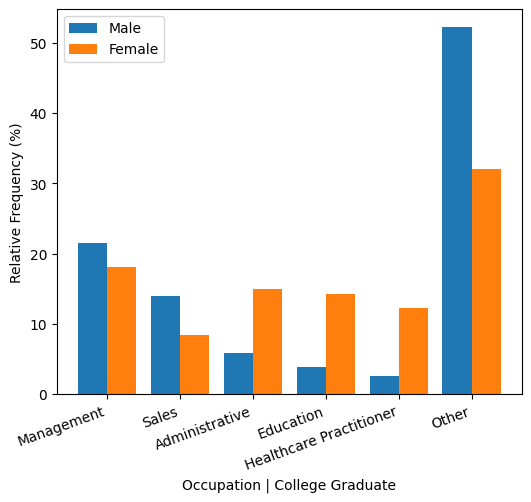

Management vs. Education: 16.66
Management vs. Healthcare: 6.29
Female vs. Male College Managers: -13.77


In [9]:
occup_names= {1 : 'Management', 2 : 'Business/Finance', 3 : 'Computer/Math', 4 : 'Architecture/Engineering', 5 : 'Life/Physical/Social Science', 
              6 : 'Community/Social Sevice', 7 : 'Legal', 8 : 'Education', 9 : 'Arts/Sports/Media', 10 : 'Healthcare Practitioner', 
              11 : 'Healthcare Support', 12 : 'Protective Services', 13 : 'Food Preparation/Serving', 14 : 'Building Cleaning/Maintenance', 
              15 : 'Personal Care', 16 : 'Sales', 17 : 'Administrative', 18: 'Farming/Fishing/Forestry', 19 : 'Construction/Mining', 
              20 : 'Installation/Repairs', 21 : 'Production', 22 : 'Transportation'}
data_male_eval['occupation'] = data_male_eval['occupation'].replace(occup_names)
data_female_eval['occupation'] = data_female_eval['occupation'].replace(occup_names)

cats_occu = ['Management', 'Sales', 'Administrative', 'Education', 'Healthcare Practitioner', 'Other']

ind = np.arange(len(cats_occu))
share0, share1 = np.zeros(len(cats_occu)), np.zeros(len(cats_occu))
for i, c in enumerate(cats_occu[:-1]):
    share0[i] = np.sum(w0*((data_male_eval['occupation'] == c) & (data_male_eval['education'] ==
                                               'College Graduate')))/np.sum(w0 * (data_male_eval['education'] ==
                                               'College Graduate'))*100
    share1[i] = np.sum(w1*((data_female_eval['occupation'] == c) & (data_female_eval['education'] ==
                                               'College Graduate')))/np.sum(w1 * (data_female_eval['education'] ==
                                               'College Graduate'))*100
share0[-1] = np.sum(w0*((~data_male_eval['occupation'].isin(cats_occu[:-1])) & (data_male_eval['education'] ==
                                               'College Graduate')))/np.sum(w0 * (data_male_eval['education'] ==
                                               'College Graduate'))*100
share1[-1] = np.sum(w1*((~data_female_eval['occupation'].isin(cats_occu[:-1])) & (data_female_eval['education'] ==
                                               'College Graduate')))/np.sum(w1 * (data_female_eval['education'] ==
                                               'College Graduate'))*100

fig = plt.figure()
fig.set_size_inches(6, 5)
plt.bar(ind, share0, 0.4, label='Male')
plt.bar(ind+0.4, share1, 0.4, label='Female')
plt.xticks(ind+0.2, cats_occu, rotation=20, ha='right')
plt.ylabel('Relative Frequency (%)')
plt.xlabel('Occupation | College Graduate')
plt.legend()
plt.show()

# Managers vs. Education
diff = (np.average(df[df['occupation'] == 1]['wage'], weights=df[df['occupation'] == 1]['weight']) - 
        np.average(df[df['occupation'] == 8]['wage'], weights=df[df['occupation'] == 8]['weight']))
print(f"Management vs. Education: {diff:.2f}")

# Managers vs. Healthcare
diff = (np.average(df[df['occupation'] == 1]['wage'], weights=df[df['occupation'] == 1]['weight']) - 
        np.average(df[df['occupation'] == 10]['wage'], weights=df[df['occupation'] == 10]['weight']))
print(f"Management vs. Healthcare: {diff:.2f}")

# Female vs. Male College Managers
diff = (np.average(data_female_eval[np.logical_and(data_female_eval['occupation'] == 'Management', data_female_eval['education'] == 'College Graduate')]['wage'], 
                   weights=w1[np.logical_and(data_female_eval['occupation'] == 'Management', data_female_eval['education'] == 'College Graduate')]) - 
        np.average(data_male_eval[np.logical_and(data_male_eval['occupation'] == 'Management', data_male_eval['education'] == 'College Graduate')]['wage'], 
                   weights=w0[np.logical_and(data_male_eval['occupation'] == 'Management', data_male_eval['education'] == 'College Graduate')]))
print(f"Female vs. Male College Managers: {diff:.2f}")